# Formative 1

### Amazon Groceries and Gourmet Food

This dataset consists of reviews of fine groceries and gourmet food from Amazon. The whole dataset contains 233.1 million reviews written from May 1996 to Oct 2018. Reviews include product and user information, ratings, and a plaintext review.

In [1]:
import re
import string
import json
import pickle
import random
import numpy as np
import pandas as pd

from html import unescape
from string import punctuation
from  matplotlib import pyplot as plt
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from sklearn.feature_extraction import stop_words

pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None

In [2]:
random.seed(0)

### Part I: Dataframe and Dictionary Setup

**Step 1**: Download the zip package. Unzip it and use the code in the Jupyter Notebook to read the normalized text in the five sets of reviews into the dataframe.

In [3]:
food_reviews_path = 'formative1_data/food_reviews.json' # Change this to the relative path on your machine

# Load data into pandas dataframe
df = pd.read_json(food_reviews_path)

# Drop columns not needed
df = df.drop(['image', 'reviewTime', 'verified', 'style'], axis=1)

# Rename and reorder dataframe columns
df.columns = ['product_id', 'category', 'score', 'text', 'user_id', 'user_name', 'summary', 'time', 'helpfulness']
df = df[['product_id', 'category', 'user_id', 'user_name', 'score', 'helpfulness', 'time', 'summary', 'text']]

In [4]:
# Define function to clean text
def clean(text):
    text = unescape(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = ' '.join([w.lower() for w in text.split()])
    return text

In [5]:
# Create column with cleaned text
df['cleaned_text'] = df.text.map(lambda x: clean(x))

In [6]:
# Convert category labels to labels used in formative
label_dict = {'coffee': 'INSTANT-COFFEE', 'tea': 'BLACK-TEA', 'chocolate': 'CHOCOLATE', 'pasta': 'PASTA', 'random': 'RANDOM'}
df['category'] = df.category.map(lambda x: label_dict[x])

In [7]:
# Check number of product categories
print(Counter(df['category']))

Counter({'INSTANT-COFFEE': 10000, 'BLACK-TEA': 10000, 'PASTA': 10000, 'CHOCOLATE': 10000, 'RANDOM': 10000})


**Step 2**: Use the code provided in the Jupyter Notebook to load the pretrained word embeddings.

In [8]:
vectors_path = 'formative1_data/fasttext_vectors.p' # Change this to the relative path on your machine

with open(vectors_path, 'rb') as f:
    vectors = pickle.load(f)

In [9]:
# Print number of embeddings and embedding dimension
print(len(vectors), len(vectors['hello']))

26399 300


In [10]:
print('HOORAY! I AM ALL SET UP AND READY TO COMPLETE THIS FORMATIVE ON TIME!')

HOORAY! I AM ALL SET UP AND READY TO COMPLETE THIS FORMATIVE ON TIME!


**Step 3**: Create dictionaries of the vocabularies for the target categories that we will be working on (INSTANT-COFFEE, BLACK-TEA, CHOCOLATE, PASTA) as well as the RANDOM set. The keys of each dictionary should be the vocabulary items, and the corresponding values should be their frequencies. A convenient way to create the dictionaries is to use the ``Counter`` class from the ``collections`` library. Remove all words on the stopword list from all of the dictionaries. Also remove all the words for which no embedding exists. Now your dictionaries contain only words that may be relevant to the semantic relationships amongst the topics, and that have embeddings.

In [11]:
print('Number of words in stopwords list:', len(stop_words.ENGLISH_STOP_WORDS))
print('10 words on the stopwords list:', list(stop_words.ENGLISH_STOP_WORDS)[:10])

Number of words in stopwords list: 318
10 words on the stopwords list: ['four', 'name', 'fill', 'than', 'were', 'once', 'must', 'who', 'and', 'afterwards']


In [12]:
# Add 't' and 's' to list of stopwords (effect of cleaning function)
stops = list(stop_words.ENGLISH_STOP_WORDS) + ['t', 's']

In [13]:
# Define function to create dictionary
def create_dict(review_list):
    # Create a list of all words in the reviews
    word_list = [w for r in review_list for w in r.strip().split()]
    # Create a dictionary of words and corresponding frequency counts using a Counter
    vocab_dict = Counter(word_list)
    # Return filtered dictionary
    return Counter({w: c for w, c in vocab_dict.items() if not w in stops and w in vectors})

In [14]:
# Create list of categories
categories = ['INSTANT-COFFEE', 'BLACK-TEA', 'CHOCOLATE', 'PASTA', 'RANDOM']

# Initialize dictionary for storing vocabularies
vocab_dicts = dict()

# Loop over categories and create vocabularies
for c_i in categories:
    vocab_dicts[c_i] = create_dict(df[df.category==c_i].cleaned_text)

In [15]:
# Inspect vocabularies of different categories
for c_i in categories:
    print('Number of unique words in {} reviews: {}'.format(c_i, len(vocab_dicts[c_i])))
    print('Most common words in {} reviews: '.format(c_i), vocab_dicts[c_i].most_common(5), end='\n\n')

Number of unique words in INSTANT-COFFEE reviews: 12012
Most common words in INSTANT-COFFEE reviews:  [('coffee', 21935), ('instant', 5941), ('like', 4764), ('good', 3721), ('taste', 3663)]

Number of unique words in BLACK-TEA reviews: 12319
Most common words in BLACK-TEA reviews:  [('tea', 29498), ('black', 5882), ('like', 4670), ('flavor', 4060), ('good', 3373)]

Number of unique words in CHOCOLATE reviews: 13163
Most common words in CHOCOLATE reviews:  [('chocolate', 18610), ('dark', 4107), ('like', 3846), ('bar', 3781), ('good', 3227)]

Number of unique words in PASTA reviews: 12095
Most common words in PASTA reviews:  [('pasta', 20282), ('like', 5433), ('noodles', 4333), ('good', 3510), ('taste', 3348)]

Number of unique words in RANDOM reviews: 14339
Most common words in RANDOM reviews:  [('like', 3451), ('good', 2987), ('taste', 2672), ('great', 2613), ('just', 2364)]



### Part II: Cosine Similarity of Words

**Step 1**: Retrieve the embeddings for the words _coffee_, _tea_, _chocolate_, and _pasta_ from the word embeddings. Also take a random sample of 200 words from the word embeddings.

In [16]:
# Create list of target words
target = ['coffee', 'tea', 'chocolate', 'pasta']

# Create list with corresponding vectors
target_vectors = [np.array(vectors[w]) for w in target]

# Sample 200 words
sample = random.sample([w for w in vectors if w not in target], 200)

# Create list with corresponding vectors
sample_vectors = [np.array(vectors[w]) for w in sample]

**Step 2**: Make a t-SNE plot in which the random words are all plotted as dots, and the points for the target words are plotted as c (_coffee_), t (_tea_), h (_chocolate_), and p (_pasta_). 

In [17]:
# Create dataset of words for t-SNE
tsne_vectors = np.array(target_vectors + sample_vectors)

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

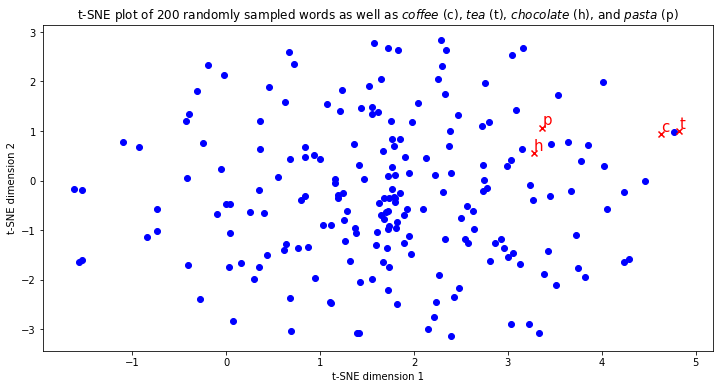

In [18]:
# Plot results
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.scatter(tsne_results[4:, 0], tsne_results[4:, 1], color='blue')

for w, p in zip(['c', 't', 'h', 'p'], tsne_results[:4]):
    ax.scatter(p[0], p[1], color='red', marker='x')
    ax.text(p[0], p[1], w, fontsize=15, color='red', ha='left', va='bottom')

ax.set_title('t-SNE plot of 200 randomly sampled words as well as $\it{coffee}$ (c), $\it{tea}$ (t), $\it{chocolate}$ (h), and $\it{pasta}$ (p)')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')

plt.show()

**Step 3**: For each of the four target words, find its cosine similarity to itself, the three other words, and all of the randomly selected words. Rank the random words by their similarity to the target word. Now make a table with 4 rows and 7 columns. The 4 rows are the four target words. The seven columns are:
- the four target words;
- the similarity for the word falling at the 5th percentile in the comparison to random words;
- the average similarity of the given target word to the random words;
- the similarity for the word falling at the 95th percentile in the comparison to random words.

In [19]:
# Define function to compute cosine similarity
def cosine_sim(v_i, v_j):
    return 1 - cosine(v_i, v_j)

In [20]:
# Initialize table as dictionary
table = dict()

for w_i in target:
    
    table[w_i] = list()
    
    # Calculate similarity to target words
    for w_j in target:
        table[w_i].append(cosine_sim(vectors[w_i], vectors[w_j]))
        
    # Sort vectors with increasing cosine similarity
    sorted_sample = sorted(sample_vectors, key=lambda x: cosine_sim(vectors[w_i], x))
    
    # Calculate similarity to sample word at 5th percentile
    v_05 = sorted_sample[int(len(sorted_sample) * 0.05) - 1]
    table[w_i].append(cosine_sim(vectors[w_i], v_05))
    
    # Calculate mean similarity to sample words
    table[w_i].append(np.mean([cosine_sim(vectors[w_i], v) for v in sample_vectors]))
    
    # Calculate similarity to sample word at 95th percentile
    v_95 = sorted_sample[int(len(sorted_sample) * 0.95) - 1]
    table[w_i].append(cosine_sim(vectors[w_i], v_95))

In [21]:
# Display table
pd.DataFrame.from_dict(table, orient='index', columns=target+['5th percentile', 'average', '95th percentile']).reindex(index=target)

,coffee,tea,chocolate,pasta,5th percentile,average,95th percentile
coffee,1.000000,0.758462,0.630488,0.430295,0.162254,0.268576,0.392918
tea,0.758462,1.000000,0.528839,0.377048,0.147866,0.259607,0.378438
chocolate,0.630488,0.528839,1.000000,0.498289,0.166502,0.288263,0.428361
pasta,0.430295,0.377048,0.498289,1.000000,0.148539,0.248815,0.392057


**A) Based on the appearance of the plot and the distances between the points, which words seem to be most similar and which seem to be least similar?**

Both the t-SNE plot and the cosine similarities suggest that the words _coffee_ and _tea_ are most similar. The points of these two words are very close to each other on the t-SNE plot, and they also have the highest mutual cosine similarity. The points of _chocolate_ and _pasta_ are further away from _coffee_ and _tea_ (as well as from each other), which is also reflected by lower cosine similarities. Notice that t-SNE is a stochastic algorithm, so two runs of t-SNE will result in slightly different plots.

**B) Why are some of the numbers in the cosine similarity table identical to each
other?**

The identical cosine similarities have two causes. First, the cosine similarity of a word to itself is always 1, which explains the identical values on the diagonal of the first four columns. Second, cosine similarity is a metric and thus symmetric, i.e., $sim(w_1, w_2) = sim(w_2, w_1)$, which explains the identical values for pairs of words.

**C) Do the similarity relations amongst the four target words according to the table
seem to be the same as in the t-SNE plot, or not?**

The results are largely similar. The words _coffee_ and _tea_ are very close to each other on the t-SNE plot, and they also have the highest mutual cosine similarity amongst the words. Furthermore, the word _chocolate_ seems to be closest to the randomly sampled words on the t-SNE plot, which is again confirmed by the cosine similarity.

**D) A common threshold for statistical significance is P < 0.05 (which means that
the probability that the outcome occurred by chance is less than 1 in 20).
Based on the information in your table, which target words are significantly
more similar to another target word than a random word would be? Are any
words significantly less similar to a target word than a random word would be?**

The word _coffee_ is significantly more similar to _tea_ and _chocolate_ and slightly past the significance threshold for _pasta_. The word _tea_ is significantly more similar to _coffee_ and _chocolate_ but not to _pasta_. The word _chocolate_ is significantly more similar to _coffee_ and _tea_ and again only slightly past the significance threshold for _pasta_. The word _pasta_ is significantly more similar to _chocolate_ and borderline for both _coffee_ and _tea_.

### Part II: Nearest Neighbors of Words

**Step 1**: Write Python code to find the 20 nearest neighbors of the probe words _coffee_, _tea_, _chocolate_, _pasta_. That is, for each target word, find its cosine distance to each of the words in the embeddings list. Rank these distances, and then find the 20 most similar words (excluding the similarity of the word to itself). Organize the nearest neighbors in a table ranked by how similar they are to the probe word (most similar at the top). 

In [22]:
# Create a list containing tuples of words and corresponding embeddings
vector_list = [(w, np.array(v)) for w, v in vectors.items()]

In [23]:
# Initialize table as dictionary
table = dict()

for w_i in target:
    
    # Rank words according to cosine similarity
    nn_list = [w for w, v in sorted(vector_list, key=lambda x: cosine_sim(vectors[w_i], x[1]), reverse=True)]
    
    # Compute 20 nearest neighbors (excluding word itself)
    table[w_i] = nn_list[1:21]

In [24]:
# Display table
pd.DataFrame.from_dict(table, orient='index').reindex(index=target)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
coffee,coffees,coffeee,tea,coffe,cappuccino,decaf,cofee,coffeeshop,cappuccinos,cocoa,frappuccino,cappucino,coffeemaker,roastery,cuppa,frappuccinos,cupper,frappucino,decaffeinated,caffe
tea,coffee,teas,cuppa,teabags,teabag,cuppas,cupper,coffe,coffees,rooibos,camomile,coffeee,cofee,biscuits,cup,oolong,decaff,darjeeling,scones,chai
chocolate,chocolates,chocolatey,chocolately,chocolaty,chocolaterie,chocolat,cocoa,choco,praline,candy,pralines,chocolatier,caramel,sweets,chocs,chocolatiers,biscuits,marshmallow,biscuit,cake
pasta,spaghetti,pastas,ravioli,carbonara,ziti,gnocchi,lasagna,macaroni,marinara,spaghettini,polenta,pesto,tortellini,rigatoni,risotto,spagetti,pizza,bruschetta,penne,bucatini


**A) In a sentence or two, comment on your nearest neighbours list in
relation to an important issue in the field, which is actual semantic similarity versus "association" or "relatedness". To what
extent do you judge that fastText is capturing semantic similarity versus
association?**

Most nearest neighbours seem to be semantically similar to the target words, e.g., _cappuccino_, _rooibos_, and _spaghetti_ are hyponyms of their respective target words. However, there are also cases of semantic relatedness such as _roastery_, _teabag_, and _chocolaterie_.

### Part III: A Quick Detour on Topics

**Step 1**: For each of the four target data sets, plus the RANDOM data set, rank the words in the dictionary from most frequent to least frequent, and store the results. Now generate 4 Zipfian rank-frequency plots, in which the log rank of a word appears on the x axis and the log frequency appears on the y axis. To repeat: this plot should be on a log-log scale. Superimpose on each plot the rank-frequency curve for the RANDOM dataset. 

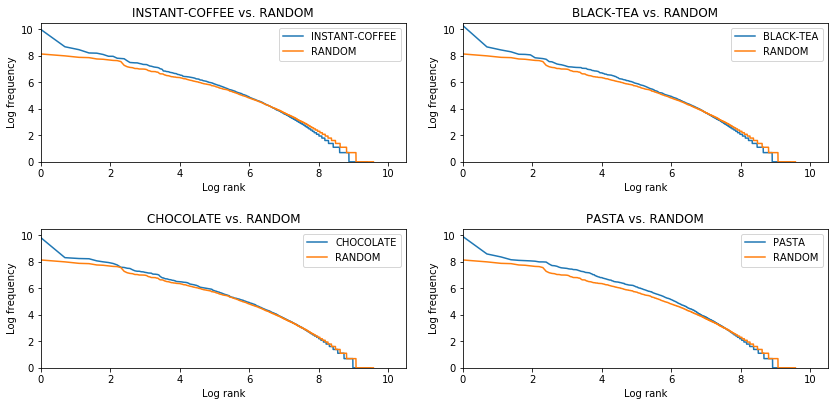

In [25]:
# Initialize dictionary to store rank-frequency distributions
freq_dists = dict()

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.ravel()

for i, c_i in enumerate(categories):
    
    # Generate list of sorted counts
    freq_dists[c_i] = [c for w, c in vocab_dicts[c_i].most_common()]
    
    # Convert to log counts
    y = [np.log(c) for c in freq_dists[c_i]]
    
    # No need to plot the comparison for the RANDOM category
    if c_i == 'RANDOM':
        continue
        
    # Generate list of sorted log counts for RANDOM category
    y_random = [np.log(c) for w, c in vocab_dicts['RANDOM'].most_common()]
    
    # Generate list of log ranks
    x = [np.log(r) for r in list(range(1, len(y) + 1))]
    x_random = [np.log(r) for r in list(range(1, len(y_random) + 1))]
    
    # Generate plot    
    axes[i].plot(x, y, label=c_i)
    axes[i].plot(x_random, y_random, label='RANDOM')
    axes[i].set_xlim(0, 10.5)
    axes[i].set_ylim(0, 10.5)
    axes[i].set_title('{} vs. RANDOM'.format(c_i))
    axes[i].set_xlabel('Log rank')
    axes[i].set_ylabel('Log frequency')
    axes[i].legend()
    
fig.tight_layout(pad=2.0)

plt.show()

**Step 2**: Now normalize your rank-frequency distributions so that they represent probabilities rather than counts.

In [26]:
# Generate dictionary to store normalized distributions
norm_freq_dists = dict()

for c_i in freq_dists:
    
    # Calculate total count
    total = np.sum(freq_dists[c_i])
    
    # Normalize counts (removing zeros)
    norm_freq_dists[c_i] = np.array([c / total for c in freq_dists[c_i]])

**Step 3**: Compute the cross-entropy between T and R, for all T. Print the numbers clearly labelled by which target T is being compared to R

In [27]:
for c_i in categories:
    
    # Skip RANDOM category
    if c_i == 'RANDOM':
        continue
    
    # Find minimum support
    min_sup = min(len(norm_freq_dists[c_i]), len(norm_freq_dists['RANDOM']))
    
    # Calculate entropy 
    e = -np.sum(norm_freq_dists[c_i][:min_sup] * np.log(norm_freq_dists[c_i][:min_sup]))
    
    # Calculate cross-entropy
    ce = -np.sum(norm_freq_dists[c_i][:min_sup] * np.log(norm_freq_dists['RANDOM'][:min_sup]))
    
    print('Entropy of {}: {}'.format(c_i, e))
    print('Cross-entropy of {} vs. RANDOM: {}'.format(c_i, ce))
    print('Difference (Kullback-Leibler divergence): {}'.format(ce - e), end='\n\n')

Entropy of INSTANT-COFFEE: 6.893148236383386
Cross-entropy of INSTANT-COFFEE vs. RANDOM: 6.990238997183322
Difference (Kullback-Leibler divergence): 0.0970907607999365

Entropy of BLACK-TEA: 6.838198060508382
Cross-entropy of BLACK-TEA vs. RANDOM: 6.966474581823959
Difference (Kullback-Leibler divergence): 0.12827652131557699

Entropy of CHOCOLATE: 7.1541512922795425
Cross-entropy of CHOCOLATE vs. RANDOM: 7.213368809167395
Difference (Kullback-Leibler divergence): 0.05921751688785282

Entropy of PASTA: 6.978546885601477
Cross-entropy of PASTA vs. RANDOM: 7.0500659835242585
Difference (Kullback-Leibler divergence): 0.07151909792278133



**A) What are the main differences you observe at the left side and at the right
side of the four plots?**

On the left side, i.e., for the most frequent words, the words in the target sets have much higher frequencies than in the random sample. On the right side, i.e., for the least frequent words, the words in the target sets have lower frequencies than in the random sample. 

**B) Why did these differences occur?**

The target sets have some highly topical words such as _coffee_ for INSTANT-COFFEE that are used much more frequently than what would be expected from their frequency in a random sample of text. 

**C) What did you decide to do about the fact that R and T don't have the same
support? What effects does your decision have on the outcome?**

One way to deal with this is to reduce the support of the distribution with the larger support. This is R in all cases considered here.

**D) The calculation of cross-entropy takes into account the ranks of the words, but
not their identity. Taking this fact into account (as well as your answer to C, if
relevant), do the numbers you got represent an upper bound, or a lower
bound, or neither, on how different the distributions really are?**

Cross-entropy as used here merely consideres rank-frequency distributions and ignores the identity of words: two distributions with identical rank frequencies and identical words on the same ranks get the same cross-entropy value as two distributions with identical rank-frequencies and completely different words. It is thus a lower bound on how different the distributions really are.

### Part IV: Similarity of Topics

**Step 1**: Compute the Jaccard similarities amongst all four target topics (INSTANT-COFFEE, BLACK-TEA, CHOCOLATE, and PASTA) by taking the intersections of the dictionaries that you have set up (more specifically, the intersections and unions of their keys). Also, find the Jaccard similarity of each target topic to the RANDOM set. Create a 4 by 5 table, where the rows are the target topics; the columns are the target topics, plus RANDOM; and the entries are the Jaccard similarity.

In [28]:
# Define function to compute Jaccard similarity
def jaccard_sim(vocab_1, vocab_2):
    intersection = len(set(vocab_1).intersection(set(vocab_2)))
    union = len(set(vocab_1).union(set(vocab_2)))
    return intersection / union

In [29]:
# Initialize table as dictionary
table = dict()

for c_i in categories:
    
    # Skip RANDOM category
    if c_i == 'RANDOM':
        continue
    
    table[c_i] = list()
    
    for c_j in categories:
        
        # Calculate Jaccard similarity
        table[c_i].append(jaccard_sim(vocab_dicts[c_i], vocab_dicts[c_j]))

In [30]:
# Display table
pd.DataFrame.from_dict(table, orient='index', columns=categories).reindex(index=[c for c in categories if c != 'RANDOM'])

,INSTANT-COFFEE,BLACK-TEA,CHOCOLATE,PASTA,RANDOM
INSTANT-COFFEE,1.000000,0.451730,0.441372,0.427041,0.443653
BLACK-TEA,0.451730,1.000000,0.450891,0.424803,0.447074
CHOCOLATE,0.441372,0.450891,1.000000,0.430400,0.456674
PASTA,0.427041,0.424803,0.430400,1.000000,0.449153


**Step 2**:  Loop over all reviews in each of the target product categories and determine
an embedding for each review. Using only the embeddings for words that appear in
your dictionary, average the word embedding vectors for the words in the text of the
review. Do two things with these embeddings:
- aggregate (sum) the embeddings to produce a vector for each product category: INSTANT-COFFEE, BLACK-TEA, CHOCOLATE, PASTA, and RANDOM;
- make a table with 4 rows and 5 columns, just like you made in Step 1.

In [31]:
# Define function to compute review embedding
def review2vector(review, vectors):
    return np.mean([vectors[w] for w in review.strip().split() if w in vectors and w not in stops], axis=0)

In [32]:
# Generate new column in dataframe containing review embeddings
df['vector'] = df['cleaned_text'].map(lambda x: review2vector(x, vectors))

In [33]:
# Create dictionary with aggregated review vectors
review_vectors = {c: np.mean(df[df.category==c].vector, axis=0) for c in categories}

In [34]:
# Initialize table as dictionary
table = dict()

for c_i in categories:
    
    # Skip RANDOM category    
    if c_i == 'RANDOM':
        continue
    
    table[c_i] = list()
    
    for c_j in categories:
        
        # Calculate Jaccard similarity
        table[c_i].append(cosine_sim(review_vectors[c_i], review_vectors[c_j]))

In [35]:
# Display table
pd.DataFrame.from_dict(table, orient='index', columns=categories).reindex(index=[c for c in categories if c != 'RANDOM'])

,INSTANT-COFFEE,BLACK-TEA,CHOCOLATE,PASTA,RANDOM
INSTANT-COFFEE,1.000000,0.972549,0.984245,0.971841,0.991750
BLACK-TEA,0.972549,1.000000,0.955827,0.941972,0.967213
CHOCOLATE,0.984245,0.955827,1.000000,0.978692,0.993864
PASTA,0.971841,0.941972,0.978692,1.000000,0.985633


**Step 3**: Take a random sample of 2500 review embeddings across all categories. This will give you approximately 500 in each category. Make a t-SNE plot of the sampling of embeddings, using the following colour scheme: green (INSTANT-COFFEE); red (BLACK-TEA); orange(CHOCOLATE); blue (PASTA); grey (RANDOM).

In [36]:
# Take sample of dataframe
df_sample = df.sample(2500)

# Create dataset of vectors for t-SNE
tsne_vectors = np.array(list(df_sample['vector']))

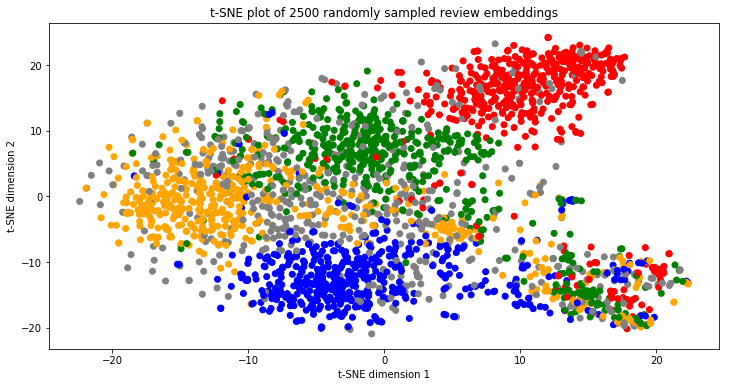

In [37]:
# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

# Plot results
category2color = {'INSTANT-COFFEE': 'green', 'BLACK-TEA': 'red', 'CHOCOLATE': 'orange', 'PASTA': 'blue', 'RANDOM':'grey'}
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], color= [category2color[c] for c in df_sample['category']])
ax.set_title('t-SNE plot of 2500 randomly sampled review embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')

plt.show()

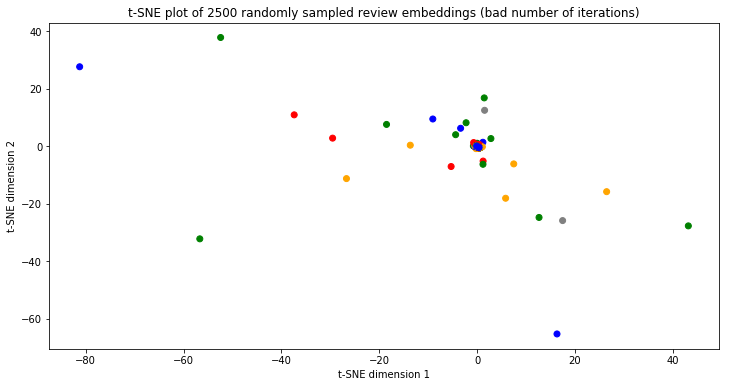

In [38]:
# Train t-SNE (bad hyperparameters I)
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=250, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

# Plot results
category2color = {'INSTANT-COFFEE': 'green', 'BLACK-TEA': 'red', 'CHOCOLATE': 'orange', 'PASTA': 'blue', 'RANDOM':'grey'}
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], color= [category2color[c] for c in df_sample['category']])
ax.set_title('t-SNE plot of 2500 randomly sampled review embeddings (bad number of iterations)')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')

plt.show()

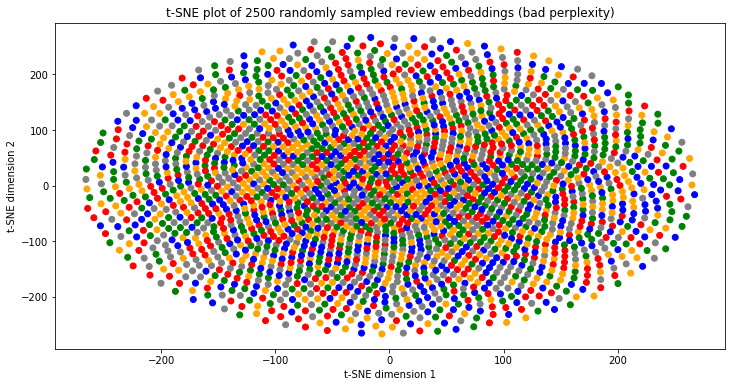

In [39]:
# Train t-SNE (bad hyperparameters II)
tsne = TSNE(n_components=2, verbose=0, perplexity=0, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

# Plot results
category2color = {'INSTANT-COFFEE': 'green', 'BLACK-TEA': 'red', 'CHOCOLATE': 'orange', 'PASTA': 'blue', 'RANDOM':'grey'}
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], color= [category2color[c] for c in df_sample['category']])
ax.set_title('t-SNE plot of 2500 randomly sampled review embeddings (bad perplexity)')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')

plt.show()

**Step 4**: Consider the topic pair INSTANT-COFFEE and CHOCOLATE. Retrieve the following sets of words:
- ONLY-CHOCOLATE (words occurring in CHOCOLATE but not INSTANT-COFFEE);
- ONLY-INSTANT-COFFEE (words occurring only in INSTANT-COFFEE but not CHOCOLATE);
- INSTANT-COFFEE $\cap$ CHOCOLATE (words occurring in both INSTANT-COFFEE and CHOCOLATE). [We had an error here, sorry!]

Use the frequency information for these sets to comment on the conjecture. 

In [40]:
# Create only-chocolate set
only_h = list(set(vocab_dicts['CHOCOLATE']).difference(vocab_dicts['INSTANT-COFFEE']))

# Calculate mean frequency of words in only-chocolate set
mean_h = np.mean([vocab_dicts['CHOCOLATE'][w] for w in only_h])
print('Mean frequency of words in ONLY-CHOCOLATE: {}'.format(mean_h))

# Create only-coffee set
only_c = list(set(vocab_dicts['INSTANT-COFFEE']).difference(vocab_dicts['CHOCOLATE']))

# Calculate mean frequency of words in only-instant-coffee set
mean_c = np.mean([vocab_dicts['INSTANT-COFFEE'][w] for w in only_c])
print('Mean frequency of words in ONLY-INSTANT-COFFEE: {}\n'.format(mean_c))

# Create intersection
both = list(set(vocab_dicts['INSTANT-COFFEE']).intersection(vocab_dicts['CHOCOLATE']))

# Calculate mean frequency of words in intersection according to INSTANT-COFFEE
mean_both_c = np.mean([vocab_dicts['INSTANT-COFFEE'][w] for w in both])
print('Mean frequency of words in intersection according to INSTANT-COFFEE: {}'.format(mean_both_c))

# Calculate mean frequency of words in intersection according to CHOCOLATE
mean_both_h = np.mean([vocab_dicts['CHOCOLATE'][w] for w in both])
print('Mean frequency of words in intersection according to CHOCOLATE: {}'.format(mean_both_h))

Mean frequency of words in ONLY-CHOCOLATE: 3.057939127246058
Mean frequency of words in ONLY-INSTANT-COFFEE: 2.7903788054845458

Mean frequency of words in intersection according to INSTANT-COFFEE: 38.28771565702426
Mean frequency of words in intersection according to CHOCOLATE: 37.20080425476716


**A) Which topic pairs are most and least similar according to the Jaccard
measure? Which topic pairs are most and least similar according to fastText
similarity? How do the values compare to the similarity of a target category to
the RANDOM category?**

According to both Jaccard and fastText similarity, the most similar topic pair is CHOCOLATE and RANDOM, and the least similar pair is BLACK-TEA and PASTA. The values are considerably clumped together though, with some of the values being higher and some being lower as compared to RANDOM. It is interesting to note that the fastText similarity values are much higher than the Jaccard similarity values and sometimes almost reach the perfect similarity score of 1.

**B) The calculation in Step 2 effectively weights word embeddings by their token
frequency. Because Jaccard
similarity uses word types as opposed to tokens, it counts every word only
once no matter how many times it appears. This observation leads to the
conjecture that the evidence for dissimilarity that goes into the Jaccard
measure is disproportionately the low-frequency words. Use the frequency information from the sets to comment on the conjecture.**

The words in the ONLY-CHOCOLATE and ONLY-INSTANT-COFFEE sets have much lower mean frequencies than the words in the intersection (difference of an order of magnitude). The many low-frequency words can be taken into account by Jaccard similarity, but they have to be disregarded by fastText if no embedding exists, which is the case for many low-frequency words. This seems to confirm the conjecture.

**C) Given your answers to the A) and B), to what extent do the Jaccard measure
and the fastText similarity measure seem to capture the same information?**

The ranking induced by both measures is similar, but the overal similarity scores differ grossly. Reviews are overall much less similar according to Jaccard similarity than fastText similarity. This might be due to the fact that Jaccard similarity can take rare words into account. At the same time, our fastText algorithm weights frequent words higher, which also leads to higher similarity values.

**D) Examine the t-SNE plot. How many distinct clusters does it seem to have?
Discuss the relationship between the clusters visible on the plot, the review
categories, and the random reviews.**

The four review categories form separate clusters. The random reviews, on the other hand, are spread across the entire embedding space without forming a clear cluster. There is one additional smaller cluster on the right side that contains embeddings from all five categories. These might be very short reviews that do not contain much topical information, thus resulting in very similar embeddings.